In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


# Milestone 2 - Arcadie

In [5]:
path_to_quotebank = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
path_to_person = '/content/drive/MyDrive/Data/person.csv'
path_to_date = '/content/drive/MyDrive/Data/date.csv' # DATE, not data :)
path_to_id_alias = '/content/drive/MyDrive/Data/id_alias.csv'
path_to_id_names = '/content/drive/MyDrive/Data/id_names.csv'
path_to_speakers = '/content/drive/MyDrive/Data/speaker_frequency.csv'
path_to_wikidata = '/content/drive/MyDrive/Project_datasets/speaker_attributes.parquet' 

import seaborn as sns
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import csv
import bz2
import json

# NLP Packages
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
nlp = en_core_web_sm.load()

# Turn of PD warning
pd.options.mode.chained_assignment = None  # default='warn'

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Data Cleaning

### 1.1 Removing quotes with no speaker

For creating our social graph we only need the quotes having:
- Speaker
- Someone mentioned in the quote


Therefore at first we remove all the quote with no speaker assigned (i.e with speaker 'None' assigned).  

The quote with no person mentioned will be skipped later directly during the creation of the graph.

In [6]:
def parse_json(json_,id):
  person_json={}
  date_json={}
  if json_['speaker']!="None":
    person_json['index']=id
    person_json['speaker']=json_['speaker']
    person_json['quotation']=json_['quotation']
    #set(person_json['quotation'].split()).intersection(set(names)).len()=11
    date_json['index']=id
    date_json['date']=json_["date"]
  return person_json, date_json
def json_to_csv(json_list, output_csv):
  keys=json_list[0].keys()
  with open(output_csv, 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(json_list)
    
def create_person_and_date(quotebank_path, person_save_path, date_save_path, max_entries, new_save = True):
  path_to_file = quotebank_path
  N = max_entries # Size of 2020 is about 3500000. It works but takes some time to load.

  person_list=[]
  date_list=[]

  with bz2.open(path_to_file, 'rb') as s_file:
    for index, instance in enumerate(s_file):
      if(index < N):
        if index%100000 == 0:
          print("{}/{}".format(index,N))
        instance= json.loads(instance) # loading a sample
        person_json,date_json=parse_json(instance,index)
        if bool(person_json) and bool(date_json):
          person_list.append(person_json)
          date_list.append(date_json)
      else:
        print("Finished at {}/{}".format(index,N))
        break
  if new_save:
    json_to_csv(person_list,person_save_path)
    json_to_csv(date_list,date_save_path)
  else:
    print("WARNING: DID NOT SAVE")

In [7]:
# new_save = False to avoid overwriting old csv. This has already been run and will be loaded, as explained below.
create_person_and_date(path_to_quotebank, path_to_person, path_to_date, 3500000, new_save=False)

0/3500000
100000/3500000
200000/3500000
300000/3500000
400000/3500000
500000/3500000
600000/3500000
700000/3500000
800000/3500000
900000/3500000
1000000/3500000
1100000/3500000
1200000/3500000
1300000/3500000
1400000/3500000
1500000/3500000
1600000/3500000
1700000/3500000
1800000/3500000
1900000/3500000
2000000/3500000
2100000/3500000
2200000/3500000
2300000/3500000
2400000/3500000
2500000/3500000
2600000/3500000
2700000/3500000
2800000/3500000
2900000/3500000
3000000/3500000
3100000/3500000
3200000/3500000
3300000/3500000
3400000/3500000
Finished at 3500000/3500000


After removing all the quotes not relavant we create two dataset and save them as csv:
- person.csv (quot_id, speaker, quote)
- date.csv (quot_id, date)  

Both dataset contains less feature with respect to the original Quotebank, since we only kept the ones that are relavant to the project. This is an important step for reducing the size of the dataset.

**person.csv** will be the main dataset we will use from now on.

### 1.2 Removing special characters

Secondly we remove all special characters not significative from our quotes.

In [8]:
data = pd.read_csv("/content/drive/MyDrive/Data/person.csv")

In [9]:
#Remove special characters
spec_chars = ['#','&','*','+',
              '/',':',';','<',
              '=','>','@','[',
              '\\',']','^','_',
              '`','{','|','}',
              '~','–']
data_removedCHAR = data.copy()

**Example of removing special characters**

In [10]:
sample = data_removedCHAR[0:4]
print("===BEFORE:===\n")
print(sample["quotation"])
for char in spec_chars:
    sample['quotation'] = sample['quotation'].str.replace(char, ' ')
    sample['quotation'] = sample['quotation'].str.replace('  ', ' ') # Remove double white spaces from above
print("\n===AFTER:===\n")
print(sample["quotation"][0:4])


===BEFORE:===

0    [ Department of Homeland Security ] was livid ...
1    [ I met them ] when they just turned 4 and 7. ...
2    [ The delay ] will have an impact [ on Slough ...
3    [ The scheme ] treats addiction as an illness ...
Name: quotation, dtype: object

===AFTER:===

0     Department of Homeland Security was livid and...
1     I met them when they just turned 4 and 7. The...
2     The delay will have an impact on Slough but t...
3     The scheme treats addiction as an illness and...
Name: quotation, dtype: object


**Removing special characters from entire set**

In [11]:
for char in spec_chars:
    data_removedCHAR['quotation'] = data_removedCHAR['quotation'].str.replace(char, ' ')
data_removedCHAR['quotation'] = data_removedCHAR['quotation'].str.replace('  ', ' ') # Remove double white spaces from above

### 1.3 Last character

We check what characters are the most frequent at the end of each quote.

In [12]:
#Check the last character of each quote 
def check_frequency_last_character(dataframe):
  data_last_element = dataframe.copy()
  
  data_last_element['last'] = data_last_element['quotation'].str[-1:]
  data_last_element = data_last_element['last'].value_counts()

  return data_last_element

print("The frequency of each last character of the quotes: \n", check_frequency_last_character(data_removedCHAR))

The frequency of each last character of the quotes: 
 ,    1584784
.    1528685
?      63596
s      41663
!      36427
      ...   
✊          1
Ö          1
¤          1
          1
          1
Name: last, Length: 146, dtype: int64


We can see that a lot of quotes finish with a comma. We would like to standardize the syntax of our quotes as much as possible so we decided to:
- replace every comma with a dot
- add a dot at the end of each quote, except the ones with a ? or a !.

**Important**: We will be doing sentiment analysis on our quotes, we need to keep ? and ! as they can be indicator of the sentiment of a text. 


In [13]:
#Add "." at the end of each quotes, unless it finishes with a ".", "?" or "!". If it is a ",", we replace the comma with a "." 
def replace_last_character(x):
    if x[-1] == '.' or x[-1] == '!' or x[-1] == '?' :
        return x
    elif x[-1] == ',':
        return x[:-1] + '.'
    else:
        return x + '.'

data_removedCHAR_lastelem = data_removedCHAR.copy()
data_removedCHAR_lastelem['quotation'] = data_removedCHAR_lastelem['quotation'].apply(replace_last_character)

print("The frequency of each last character of the quotes : \n", check_frequency_last_character(data_removedCHAR_lastelem))

The frequency of each last character of the quotes : 
 .    3343582
?      63596
!      36427
Name: last, dtype: int64


Saving the results in the person.csv file.

In [14]:
data=data_removedCHAR_lastelem
data.to_csv(path_to_person, index=False)

### 1.4 External dataset - speaker_attributes

We decided to use the external dataset speaker_attributes.parquet in order to address the problem of recognizing people mentioned in the quotes.

So we imported the dataset and created two others out of it:
- id_names (speaker_id, label, aliases)
- id_alias (speaker_id, alias): This dataset is created because, when we want to assign a speaker_id to a person found in a quote, we search for the alias and then we assign the id, since the same speaker may have different aliases (Donald Trump, Presisent Trump). 

During the creation of id_names and id_aliases we adressed some problems in the speaker_attributes.parquet:
1. The entries with no aliases had the aliases value empty. We created a list containing only the label as alias for these entries since later we want to look only to aliases for assignin the speaker id.
2. Many entries have None elements in the label column and they have been removed.
3. Some entries are duplicated, which means they have same label and same aliases. The duplicates have been removed, and only the orignals are kept.

In [15]:
def create_id_names_alias(path_to_wikidata, save_path_id_names, save_path_id_alias, speakers_unique, new_save = True):

  extra_data = pd.read_parquet(path_to_wikidata)
  id_names=extra_data[['id','label','aliases']]
  del(extra_data)
  
  #replacing empty values of column aliases with label
  id_names.loc[id_names['aliases'].isnull(),'aliases']=id_names.loc[id_names['aliases'].isnull(),'label'].apply(lambda x: np.array([x]))
  
  #adding label to alias list
  id_names.aliases=id_names.apply(lambda x: list(set(x.aliases).union(set([x.label]))), axis=1)
  
  #Removing Rows containing None elements
  print(f'Shape with Nones:{id_names.shape}')
  id_names=id_names.dropna()
  print(f'Shape without Nones:{id_names.shape}')
  
  #Inner join with speakers
  #Speakers contains aliases. If is true that if an alias is present also the label it is, then we don't have loss of data. This must be verified.
  print(f'Shape before inner-join:{id_names.shape}')
  id_names=id_names.join(speakers_unique.set_index('speaker'), on='label',how="inner")
  print(f'Shape after inner-join:{id_names.shape}')

  #drop duplicates having same aliases
  print(f'Shape with duplicates:{id_names.shape}')
  #idn_copy is needed to transform list in string in order to make them comparable in the method drop_duplicates
  idn_copy=id_names.copy()
  idn_copy.aliases=idn_copy.aliases.apply(lambda x: str(x))
  idn_copy=idn_copy.drop_duplicates(subset=['label','aliases'],keep='first')
  id_names=id_names.join(idn_copy.set_index('id'), on='id',how="inner",rsuffix="_copy")
  id_names = id_names[id_names.columns.drop(list(id_names.filter(regex='_copy')))]
  print(f'Shape without duplicates:{id_names.shape}')

  #create id_alias
  id_alias=id_names.apply(lambda x: pd.Series(x['aliases']),axis=1).stack().reset_index(level=1, drop=True)
  id_alias.name='alias'
  id_alias=id_names.drop('aliases',axis=1).join(id_alias).drop('label',axis=1)
   
  if new_save:
    id_alias.to_csv(save_path_id_alias, index=False)
    id_names.to_csv(save_path_id_names, index=False)
  else:
    print("WARNING: DID NOT SAVE")
  return id_names, id_alias

In [16]:
#Create speaker unique value
speakers_unique=pd.DataFrame(data.speaker.unique())

speakers_unique.set_axis(["speaker"],axis=1,inplace=True)
id_names, id_alias=create_id_names_alias(path_to_wikidata,path_to_id_names,path_to_id_alias,speakers_unique)

#Remove DataFrame no longer needed
del(speakers_unique)

Shape with Nones:(9055981, 3)
Shape without Nones:(8543681, 3)
Shape before inner-join:(8543681, 3)
Shape after inner-join:(533278, 3)
Shape with duplicates:(533278, 3)
Shape without duplicates:(252402, 3)


In [17]:
id_alias = pd.read_csv(path_to_id_alias)
id_names = pd.read_csv(path_to_id_names)

## 2. Data Analysis

### 2.1 Distribution of speakers

We identify the distribution of the column "speaker", what are the names that are the most frequent and other statistical metrics.

In [18]:
speaker_frequency = data['speaker'].value_counts()
speaker_frequency.head(10)

President Donald Trump    28023
Bernie Sanders            13189
Joe Biden                 12817
President Trump           12415
Andrew Cuomo              11088
Narendra Modi              8239
Elizabeth Warren           7647
Donald Trump               7104
Boris Johnson              6952
Scott Morrison             6601
Name: speaker, dtype: int64

Text(0.5, 1.0, 'Distribution of the frequencies of speaker alias')

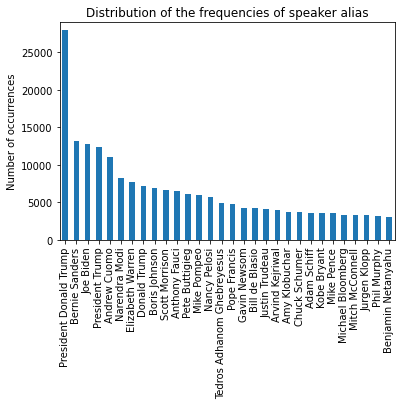

In [19]:
# histogram plot 
speaker_frequency.head(30).plot.bar()
plt.ylim((0,29000))
plt.ylabel('Number of occurrences')
plt.title('Distribution of the frequencies of speaker alias')


In [20]:
#describe
speaker_frequency.describe()

count    218414.000000
mean         15.766411
std         112.704624
min           1.000000
25%           2.000000
50%           4.000000
75%          11.000000
max       28023.000000
Name: speaker, dtype: float64

**Conclusions**
- Trump is the most frequent speaker 
- There are 198,746 unique speakes ( Based on alias )
- The most frequent speakers are politicians, especially US politicians. However, speakers such as Angela Merkel and Vladimir Putin do appear.

The social graph is likely to map political relations rather than interpersonal relationships.


### 2.2 Distribution of mentioned people

Now we look at what persons (their aliases) are mentioned the most, is the dataset biased to be about a certain person or topic?

- **Note 1:** We first take 40 samples of our cleaned dataset, this is then used in two different ways shown in this section (2.2) and the next (2.3).
- **Note 2:** We remove speakers that only occur once, since usually this is just noise from the Spacy NLP. 

In [21]:
def create_mentioned_persons(data, save_path, max_entries, new_save = True, start_idx = 0):
  data_chunk = data[start_idx:start_idx+max_entries]
  N = (data_chunk.size)/3

  mentioned_persons = pd.DataFrame(columns=['person','value'])
  index_ = 0
  for index, row in data_chunk.iterrows():
    doc = nlp(row['quotation'])
    index_ += 1
    if index_%1000 == 0:
      print("{}/{}".format(index_,N))
    for ent in doc.ents:
      if ent.label_ == "PERSON":
        mentioned_persons = mentioned_persons.append({'person':ent.text,'value':1}, ignore_index=True)
  if new_save:
    mentioned_persons.to_csv(save_path, index=False)
  else:
    print("WARNING: DID NOT SAVE")

  return mentioned_persons

In [22]:
# Create samples
samples = []

sample_size = 1000
sample_increment = 50000

# Get number of mentioned persons
for k in range(0,40):
  print(k)
  samples.append(create_mentioned_persons(data, "null", sample_size, new_save = False, start_idx = k*sample_increment))

0
1000/1000.0
1
1000/1000.0
2
1000/1000.0
3
1000/1000.0
4
1000/1000.0
5
1000/1000.0
6
1000/1000.0
7
1000/1000.0
8
1000/1000.0
9
1000/1000.0
10
1000/1000.0
11
1000/1000.0
12
1000/1000.0
13
1000/1000.0
14
1000/1000.0
15
1000/1000.0
16
1000/1000.0
17
1000/1000.0
18
1000/1000.0
19
1000/1000.0
20
1000/1000.0
21
1000/1000.0
22
1000/1000.0
23
1000/1000.0
24
1000/1000.0
25
1000/1000.0
26
1000/1000.0
27
1000/1000.0
28
1000/1000.0
29
1000/1000.0
30
1000/1000.0
31
1000/1000.0
32
1000/1000.0
33
1000/1000.0
34
1000/1000.0
35
1000/1000.0
36
1000/1000.0
37
1000/1000.0
38
1000/1000.0
39
1000/1000.0


Text(0.5, 1.0, 'Distribution of person aliases mentioned in 40 samples\n of 1000 quotes over 2,000,000 quotes')

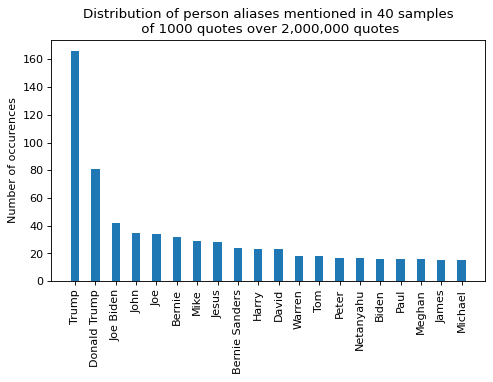

In [23]:
# Get distribution of mentioned persons 
mentioned_persons = pd.DataFrame(columns = ['name', 'count'])
for sample in samples:
  persons_aggregated = sample.groupby('person').count().sort_values('value',ascending=False)
  persons_aggregated = persons_aggregated.rename(columns={"persons": "name", "value": "count"}).reset_index()
  mentioned_persons = pd.concat([mentioned_persons,persons_aggregated])
mentioned_persons = mentioned_persons.groupby('person').sum().sort_values('count',ascending=False)
mentioned_persons = mentioned_persons.drop(labels='name', axis=1)
mentioned_persons = mentioned_persons.loc[mentioned_persons['count'] > 1].reset_index() # Filter noise

mentioned_persons.head(20)

figure(figsize=(7, 4), dpi=80)
f = plt.bar(mentioned_persons.head(20)['person'],mentioned_persons.head(20)['count'], width=0.4)
plt.xticks(rotation=90)
plt.ylabel("Number of occurences")
plt.title("Distribution of person aliases mentioned in 40 samples\n of 1000 quotes over 2,000,000 quotes")

**Conclusions**
- Likewise to speakers of quotes, Trump is the most common person to be mentioned in a quote.
- A difficulty is apparent: Persons are usually not mentioned by their full name. This is what we fixed by creating the id_aliases and id_names, we map aliases of persons to their full name using the wikidata dataset for speakers.
- We must make guesses when mapping alias to full name, and since the dataset seems to be centered around the 2020 US election we can assume that Bernie, Joe and Mike refer to Bernie Sanders, Joe Biden, Mike pence.
- Jesus is a popular dude. 

**Reflection**
- This analysis might detect mentioned persons that were wrongly detected as speakers by the Quobert model. However, it can also be interesting to see in the final result if it is common for a person to mention themselves.

### 2.3 Distribution of number of quotes containing a mention

One important step for understanding if the project is feasible is considering if we have enough quotations containing a mention.

A first approach for getting a hint of the amount of these particular quotations without computing all of them is considering only sub-samples with fixed size.

By using the samples created before we measure and plot how many quotes in the sample contain a mention.

This may give us an approximative idea if there is enough data for the project.

Average number of mentioned persons per 1000 quotes: 30


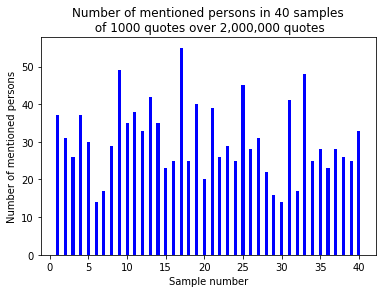

In [24]:
# Get number of mentioned persons in the sample quotes
number_of_mentioned_persons = []
for sample in samples:
  persons_aggregated = sample.groupby('person').count().sort_values('value',ascending=False)
  persons_aggregated = persons_aggregated.loc[persons_aggregated['value'] > 1] # Filter noise
  number_of_mentioned_persons.append(persons_aggregated.sum(axis=0))

sum_np = np.asarray(number_of_mentioned_persons)
x = np.arange(1,41).reshape(40,1)
x = [int(i) for i in list(x)]
sum_np = [int(i) for i in list(sum_np)]

#plt.bar(x,sum_np)
plt.bar(x, sum_np, color ='blue',
        width = 0.4)
plt.xlabel("Sample number")
plt.ylabel("Number of mentioned persons")
plt.title("Number of mentioned persons in 40 samples\n of 1000 quotes over 2,000,000 quotes")

print("Average number of mentioned persons per 1000 quotes:",int(np.asarray(sum_np).mean()))

**Conclusion**
- Given the results, it is reasonable to assume that there is an even distribution of quotes over the entire dataset that contains a mention of one or more persons.
- There are on average 30 mentioned persons (not unique) per 1000 quotes. The cleaned dataset contains about 3000 * 1000 quotes which means that about 90,000 quotes mention a person.
- There is probably enough data to create a sufficient social graph. 

### 2.4 Distribution of the sentimental analysis results over the quotes

Before creating the social graph, it may be of interest looking at the distribution of the sentimental analysis results over the quotes.

We are using the library nltk where we import SentimentIntensityAnalyzer. When passing a quote, the SentimentIntensityAnalyzer will return 4 numbers corresponding to : 

- negative: the negative sentiment in a sentence
- neutral: the neutral sentiment in a sentence
- positive: the positive sentiment in the sentence
- compound: the aggregated sentiment


**What we expect**:  
At first, we may naivly expect most of the quote to be negative with respect to the speaker, since usually in the journalism the articles containing criticism and aggressive discussion are the most read because they arouse curiosity in the reader.

In [25]:
def get_avg_pos_neg_comp_sentiment(data, max_entries, start_idx = 0):
  data_chunk = data[start_idx:start_idx+max_entries]
  N = (data_chunk.size)/3

  positive = []
  neutral = []
  negative = []  
  compound = []
  index_ = 0
  for index, row in data_chunk.iterrows():
    score=sia.polarity_scores(row['quotation'])
    positive.append(score['pos'])
    neutral.append(score['neu'])
    negative.append(score['neg'])
    compound.append(score['compound'])
    index_ += 1
  positive = np.asarray(positive).mean()
  neutral = np.asarray(neutral).mean()
  negative = np.asarray(negative).mean()
  compound = np.asarray(compound).mean()

  return positive, neutral, negative, compound

In [26]:
positive = []
negative = []
neutral = []
compound = []
sample_size = 50
sample_increment = 1000

for k in range(0,2000):
  if k%100 == 0:
    print(k)
  pos, neu, neg, comp = get_avg_pos_neg_comp_sentiment(data, sample_size, start_idx = k*sample_increment)
  positive.append(pos)
  neutral.append(neu)
  negative.append(neg)  
  compound.append(comp)  

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


Text(0.5, 1.0, 'Distribution of positive, negative, neutral sentiment score\n in 2000 samples of 50 quotes over 2,000,000 quotes')

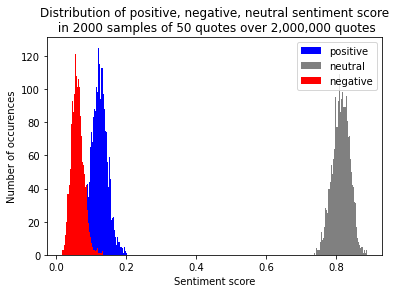

In [27]:
plt.hist(positive, bins=50, color='blue',label="positive")
plt.hist(neutral, bins=50, color='gray',label="neutral")
plt.hist(negative, bins=50, color='red',label="negative")
plt.legend(loc="upper right")
plt.ylabel("Number of occurences")
plt.xlabel("Sentiment score")
plt.title("Distribution of positive, negative, neutral sentiment score\n in 2000 samples of 50 quotes over 2,000,000 quotes")

Text(0.5, 1.0, 'Distribution of compound sentiment score in 2000 samples\n of 50 quotes over 2,000,000 quotes')

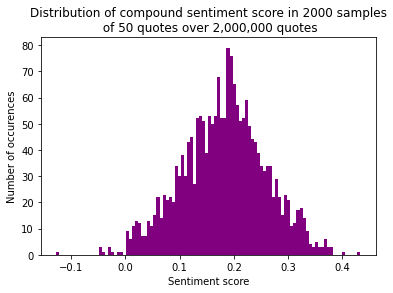

In [28]:
plt.hist(compound, bins=100, color='purple')
plt.ylabel("Number of occurences")
plt.xlabel("Sentiment score")
plt.title("Distribution of compound sentiment score in 2000 samples\n of 50 quotes over 2,000,000 quotes")


**Conclusion**
- Most quotes are quite neutral: The newspapers probably make sure that the content is kept reasonably formal and not personal.
- As mentioned before, the quotes are probably about the election and politicians tend to stay neutral to avoid unecessary conflicts.
- It might be required to filter out the neutral scores to obtain a compound score that reflects if the quote sentiment is negative or positive since the neutral score dominates as a weight in the compound score.

## 3. Graph Creation

After the cleaning and the analysis of the data we start implementing the graph creation.

The graph is stored in a DataFrame with the following columns:
- quot_id
- speaker_id
- mention_id
- compound: measure of the positivity/negativity of the quote

The construction of the graph follows this steps for each quote:
1. We tokenize the quote by using the NLP library **spacy**.
2. For each token in the quote we check if it appears in the id_alias dataset. If this is the case then the token represents a person.
**Important:** By using the id_alias dataset we are implementing the assignement by alias and not directly by label which may be limitating.
3. We apply sentimental analysis on the quote and we obtain the compound measure.  
**Important:** We decided to use the compound measure of sentiment instead of the triplet (negative, netural, positive) because we want to use a single parameter. In the future we may consider to build a custom more appropriate single measurement by combining the values of the triplet in a specific way.
4. After we computed all the elements we append it to the graph by adding it to the DataFrame.

In [29]:
def find_id(nouns):
  for noun in nouns:
    result=id_alias[id_alias.alias==noun]
    if not result.empty:
      return result.id.values[0]
  return ""

We test the code on a sample of 200 quotes.

It is important to notice how roughly **10%** of the quotes contribute to the population of the graph.  

If this rate keeps constant on the whole dataset, since our final quotes dataset has 3.5 million elements, we may expect to have approximately 300'000 entries in the graph.

This quantity of data in the graph should be enough to continue our study (e.g: applying clustering and observing if political parties or other well-known groups emerge).

We compute the distance between the edges from the compound measure obtained from the sentimental analysis.

In [31]:
#function for distance
def distance(x):
  return 1/(np.exp((1-x)/(x+1)))

In [32]:
#create graph dataframe
graph=pd.DataFrame({'quot_id':[],'speaker_id':[],"mention_id":[],"compound":[], "distance":[]})

#populate the graph
for i,row in enumerate(data.values):
  N=200
  if i<N:
    if i%50==0:
      print(f'{i}/{N}')
    quotation_id=int(row[0])
    speaker_id=find_id([row[1]])
    quotation=row[2]
    doc = nlp(quotation)
    nouns=[x.text for x in doc.ents]
    mention_id=find_id(nouns)
    if mention_id and speaker_id:
      score=sia.polarity_scores(quotation)
      dict_={'quot_id':int(quotation_id),'speaker_id':speaker_id,'mention_id':mention_id,"compound":score['compound'], "distance":distance(score['compound'])}
      graph=graph.append(dict_,ignore_index=True)
      print('Element appended to the graph. :)')

0/200
Element appended to the graph. :)
Element appended to the graph. :)
50/200
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
100/200
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
150/200
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)
Element appended to the graph. :)


**Conversion to networkx**

In [33]:
graph

,quot_id,speaker_id,mention_id,compound,distance
0,10.0,Q5220272,Q6279,0.0000,0.367879
1,68.0,Q4954264,Q43162328,0.8750,0.935507
2,101.0,Q7185804,Q5325563,0.8586,0.926743
3,103.0,Q58166424,Q5546084,-0.6444,0.009811
4,136.0,Q6222401,Q22686,-0.8020,0.000112
5,138.0,Q56515295,Q150502,0.0000,0.367879
6,148.0,Q979221,Q254820,0.7003,0.838397
7,153.0,Q373912,Q6235957,-0.6283,0.012517
8,174.0,Q220579,Q677871,0.2023,0.515057
9,179.0,Q892014,Q892014,-0.2023,0.221528


We conclude by plotting the graph using the **networkx** library.

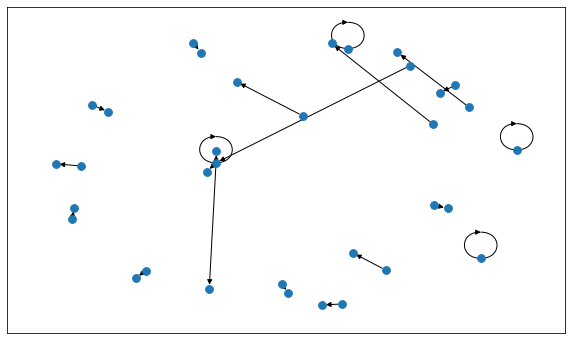

In [35]:
import networkx as nx

records =graph[['speaker_id','mention_id','distance']].to_records(index=False)
result = list(records)
FG = nx.Graph()
FG.add_weighted_edges_from(result)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
nx.draw_networkx(FG, ax=ax, with_labels=FalseS, node_size = 60, arrows=True)